O objetivo deste case é encontrar qual transportadora realizou o transporte de madeira com maior custo-benefício e construir um modelo preditivo que prevê o preço do transporte em dezembro de 2007 por transportadora utilizando as variáveis do problema.

O dataset utilizado corresponde apenas aqueles com origem no estado do Acre e no ano de 2007. O dataset pode ser baixado no link abaixo.

[http://dadosabertos.ibama.gov.br/dataset/documento-de-origem-florestal-dof-transportes-de-produtos-florestais](http://dadosabertos.ibama.gov.br/dataset/documento-de-origem-florestal-dof-transportes-de-produtos-florestais)



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size = 18)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cols = ['Nome/Razão Social do Remetente', 'CPF/CNPJ do Remetente', 'Município de Origem', 
        'Latitude de Origem', 'Longitude de Origem', 'Município de Destino', 
        'Latitude do Destino', 'Longitude do Destino', 'Data de Emissão', 
        'Produto', 'Volume', 'Valor (R$)']

df = pd.read_excel("/content/drive/My Drive/UFS/case_cnpq/2007.xlsx", usecols=cols)

### Vejamos o total de minicípios distintos de origem, destino e o total de produtos distintos.

In [4]:
print(f"Total de Município de Origem {np.unique(df['Município de Origem']).shape[0]}")
print(f"Total de cidades Destino {np.unique(df['Município de Destino']).shape[0]}")
print(f"Total de produtos distintos {np.unique(df['Produto']).shape[0]}")

Total de Município de Origem 18
Total de cidades Destino 121
Total de produtos distintos 24


### Verificando os numeros de linhas para cada coluna sem valores

In [5]:
for col in df.columns:
    nuls_value = df[col].isna().sum()
    percentage = 100*(nuls_value/df.shape[0])
    message = f'Coluna "{col}" tem {nuls_value} linhas nulas / {percentage :.2f}%'
    print(message)

Coluna "Nome/Razão Social do Remetente" tem 0 linhas nulas / 0.00%
Coluna "CPF/CNPJ do Remetente" tem 0 linhas nulas / 0.00%
Coluna "Município de Origem" tem 0 linhas nulas / 0.00%
Coluna "Latitude de Origem" tem 0 linhas nulas / 0.00%
Coluna "Longitude de Origem" tem 0 linhas nulas / 0.00%
Coluna "Município de Destino" tem 0 linhas nulas / 0.00%
Coluna "Latitude do Destino" tem 26327 linhas nulas / 68.43%
Coluna "Longitude do Destino" tem 26341 linhas nulas / 68.46%
Coluna "Data de Emissão" tem 0 linhas nulas / 0.00%
Coluna "Produto" tem 0 linhas nulas / 0.00%
Coluna "Volume" tem 0 linhas nulas / 0.00%
Coluna "Valor (R$)" tem 1188 linhas nulas / 3.09%


### Coletando os 5 municipios com maior destino sem as latitude e/ou longitude

In [6]:
total=df["Município de Destino"][df['Longitude do Destino'].isna()].value_counts()[:5].sum()
percetage = 100 * (total/df['Longitude do Destino'].isna().sum())
print(f'Total de {total} dos 5 mais | {percetage :.2f}%')

Total de 23171 dos 5 mais | 87.97%


### Quais são os nomes destes múnicipios?

In [7]:
df["Município de Destino"][df['Longitude do Destino'].isna()].value_counts()[:5]

RIO BRANCO         13710
PORTO ACRE          5760
CRUZEIRO DO SUL     1820
ACRELANDIA          1187
SENA MADUREIRA       694
Name: Município de Destino, dtype: int64

### Sera que estas latitudes e longitudes em que estão faltando corresponde as entregas realizadas no mesmo municipio de origem?

In [8]:
df2 = df[df["Longitude do Destino"].isna()]

origem_destino_igual = df2[df2["Município de Destino"]==df2["Município de Origem"]].shape[0]
print(f"Temos {origem_destino_igual} em que o Município de Destino e Município \
de Origem são os mesmos | {100*origem_destino_igual/df2.shape[0] :.2f}%")
print(f"Temos {df2.shape[0]-origem_destino_igual} em que o Município de Destino e Município \
de Origem são diferentes | {100*(df2.shape[0]-origem_destino_igual)/df2.shape[0] :.2f}%")

Temos 9079 em que o Município de Destino e Município de Origem são os mesmos | 34.47%
Temos 17262 em que o Município de Destino e Município de Origem são diferentes | 65.53%


De um total de ``26341`` linhas que não tem latitude e/ou longitude preenchidos, apenas ``9079`` (``34.5``%) dos dados as entregas são feitas no mesmo Município de Origem.

Como observado acima, das entregas em que não foram preenchidas a latitude/longitude, os 5 municípios de destino com maior numero de entragas correspondem à 88% de todo os dados faltantes. Assim coletaremos essas informações e faremos o preenchimento do DataFrame. 

Coletando a latitude e longitude destes múnicipios

- Rio Brando 
 - Latitude: -9.974, Longitude: -67.8076
- Porto Acre
 - Latitude -9.57632, Longitude: -67.5508
- Cruzeiro do Sul
 - Latitude: -7.6649, Longitude: -72.6504 
- Acrelandia
 - Latitude: -9.82538, Longitude: -66.8865 
- Sena madureira
 - Latitude: -9.06721, Longitude: -68.6577

### dicionario com lat/long dos 5 minicípios

In [9]:
coord = {}
coord['RIO BRANCO'] = {
    'Latitude': -9.974, 'Longitude': -67.8076
}
coord['PORTO ACRE'] = {
    'Latitude': -9.57632, 'Longitude': -67.5508
}
coord['CRUZEIRO DO SUL'] = {
    'Latitude': -7.6649, 'Longitude': -72.6504
}
coord['ACRELANDIA'] = {
    'Latitude': -9.82538, 'Longitude': -66.8865 
}
coord['SENA MADUREIRA'] = {
    'Latitude': -9.06721, 'Longitude': -68.6577
}

### Substituindo as Latitudes e Longitudes destes múnicipios em que nas linhas com ``NaN``

In [10]:
for destino in coord.keys():
    df["Latitude do Destino"][df["Município de Destino"]==destino] = df["Latitude do Destino"][df["Município de Destino"]==destino].replace(np.nan, coord[destino]['Latitude'])
    df["Longitude do Destino"][df["Município de Destino"]==destino] = df["Longitude do Destino"][df["Município de Destino"]==destino].replace(np.nan, coord[destino]['Longitude'])

### Excluindo as demais linhas que ainda apresentem `NaN`

In [11]:
df = df.dropna()

### Verificando se ainda tem alguma linha com `NaN`

In [12]:
for col in df.columns:
    nuls_value = df[col].isna().sum()
    percentage = 100*(nuls_value/df.shape[0])
    message = f'Coluna "{col}" tem {nuls_value} linhas nulas / {percentage :.2f}%'
    print(message)

Coluna "Nome/Razão Social do Remetente" tem 0 linhas nulas / 0.00%
Coluna "CPF/CNPJ do Remetente" tem 0 linhas nulas / 0.00%
Coluna "Município de Origem" tem 0 linhas nulas / 0.00%
Coluna "Latitude de Origem" tem 0 linhas nulas / 0.00%
Coluna "Longitude de Origem" tem 0 linhas nulas / 0.00%
Coluna "Município de Destino" tem 0 linhas nulas / 0.00%
Coluna "Latitude do Destino" tem 0 linhas nulas / 0.00%
Coluna "Longitude do Destino" tem 0 linhas nulas / 0.00%
Coluna "Data de Emissão" tem 0 linhas nulas / 0.00%
Coluna "Produto" tem 0 linhas nulas / 0.00%
Coluna "Volume" tem 0 linhas nulas / 0.00%
Coluna "Valor (R$)" tem 0 linhas nulas / 0.00%


----

### Criando novas colunas

#### Coletar apenas o mês de emissão da coluna Data de Emissão


In [13]:
df['mes'] = df['Data de Emissão'].dt.month
df['mes'].value_counts()

9     7665
8     6898
10    5665
11    4673
7     3651
6     1613
12    1253
5      823
2      579
4      543
1      447
3      437
Name: mes, dtype: int64

### Distância em Km entre origem e destino

In [14]:
from math import sin, cos, sqrt, atan2, radians 
def distance(lati_o,long_o,lati_d,long_d): 
    # Raio aproximado da terra 
    R = 6371.0 
 
    lat1 = radians(lati_o) 
    lon1 = radians(long_o) 
    lat2 = radians(lati_d) 
    lon2 = radians(long_d) 
 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
    c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
 
    distance = R * c 
 
    return distance 

In [15]:
df["Distancia_Km"] = list(map(distance,df["Latitude de Origem"], df["Longitude de Origem"], df["Latitude do Destino"], df["Longitude do Destino"]))

null = (df['Distancia_Km']==0).sum()
message = f'Tem {null} linhas com distância nula. '
print(message)

Tem 34 linhas com distância nula. 


In [16]:
# Excluindo estas linhas com distância nula. 
# Esse valor deve ter ocasionado pelo fato da entrega tenha sido feito na mesma cidade
# e o preenchimento aproximado das mesmas

df.drop(df[df['Distancia_Km']==0].index, inplace=True)

null = (df['Distancia_Km']==0).sum()
message = f'Tem {null} linhas com distância nula. '
print(message)

Tem 0 linhas com distância nula. 


### Converter os nomes dos produtos por numeros

In [17]:
# criando uma lista dos tipos de madeiras realizadas nas entregas
# em ordem decrescente 
produto = list(df['Produto'].value_counts().index)

# construindo um dicionário em que converte o nome do produto em numero
produto_convert_num = {p:cont for cont,p in enumerate(produto,1)}

# construindo um dicionário que informa qual numero corresponde ao produto
num_convert_produto = {produto_convert_num[p]:p for p in produto_convert_num.keys()}

# aplicando a transformação
df['Produto_Num'] = df['Produto'].apply(lambda x: produto_convert_num[x])

# Melhor Custo Beneficio

Agora que temos a distância das entregas, vamos definir o custo beneficio. Vamos definir 3 custo beneficio:

- *custo_beneficio*: Razão entre o valor cobrado e o produto entre a distância da entrega e o volume da mercadoria;

- *custo_beneficio_por_KM*: Razão entre o valor cobrado e a distância da entrega;

- *custo_beneficio_por_Volume*: Razão entre o valor cobrado e o volume da mercadoria;


In [18]:
df["Custo_Beneficio"]=df['Valor (R$)']/(df['Distancia_Km']*df['Volume'])
df["Custo_Beneficio_por_KM"]=df['Valor (R$)']/df['Distancia_Km']
df["Custo_Beneficio_por_Volume"]=df['Valor (R$)']/df['Volume']

> Obs.: Aqui não estou levando em considerção o tipo de madeira que é transportada. Existem maderias que são mais valorizadas que outras. Para realizar essa analise, teriamos que ter uma base de dados com tais informações.
 



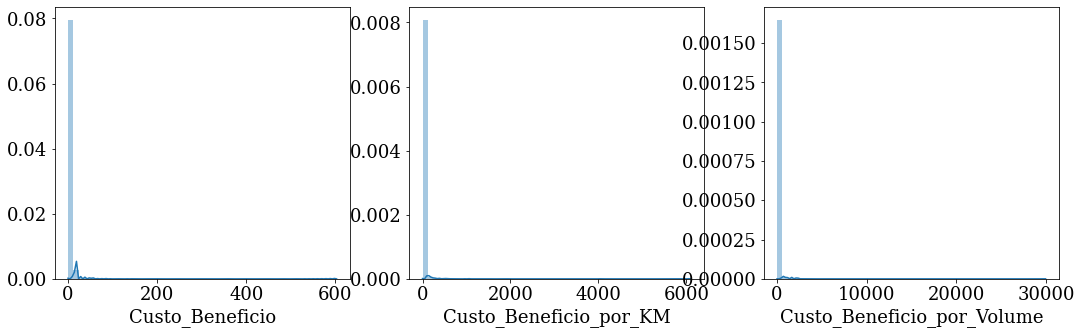

In [21]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.distplot(df["Custo_Beneficio"])
plt.subplot(1,3,2)
sns.distplot(df["Custo_Beneficio_por_KM"])
plt.subplot(1,3,3)
sns.distplot(df["Custo_Beneficio_por_Volume"]);

Existe uma concentração próximo de zero. Será que tem valores de fretes igual a zero?

In [22]:
print(f"Existe linhas {(df['Valor (R$)'] == 0.0).sum()} do total de {df.shape[0]} \
em que o valor do frete é igual a zero.")

Existe linhas 5793 do total de 34213 em que o valor do frete é igual a zero.


Valor do frete nulo não faz sentido para o negocio. Assim vamos excluir tais linhas em vez de realizar algum preenchimento destes valores.

In [23]:
df = df[df['Valor (R$)'] != 0.0]

### Custo beneficio médio de cada empresa.

O que seria este custo beneficio médio? 

- *Custo_Beneficio_Medio*: Podemos interpretalo como a taxa média do valor cobrado do frete em que cada empresa cobraria por kilometro rodado e por volume transportado. 

- *Custo_Beneficio_Medio_por_KM*: Podemos interpretalo como a taxa média do valor cobrado do frete em que cada empresa cobraria por kilometro rodado. 

- *Custo_Beneficio_Medio_por_Volume*: Podemos interpretalo como a taxa média do valor cobrado do frete em que cada empresa cobraria por volume transportado. 

In [24]:
custo_beneficio_medio = {}
custo_beneficio_medio['Nome/Razão Social do Remetente'] = []
custo_beneficio_medio['Custo_Beneficio_Medio'] = []
custo_beneficio_medio['Custo_Beneficio_Medio_por_KM'] = []
custo_beneficio_medio['Custo_Beneficio_Medio_por_Volume'] = []
for empresa in np.unique(df['Nome/Razão Social do Remetente']):
    custo_beneficio_medio['Nome/Razão Social do Remetente'].append(empresa)
    c = df[df['Nome/Razão Social do Remetente'] == empresa]['Custo_Beneficio'].mean()
    c_KM = df[df['Nome/Razão Social do Remetente'] == empresa]['Custo_Beneficio_por_KM'].mean()
    c_Volume = df[df['Nome/Razão Social do Remetente'] == empresa]['Custo_Beneficio_por_Volume'].mean()
    custo_beneficio_medio['Custo_Beneficio_Medio'].append(c)
    custo_beneficio_medio['Custo_Beneficio_Medio_por_KM'].append(c_KM)
    custo_beneficio_medio['Custo_Beneficio_Medio_por_Volume'].append(c_Volume)

df_CBM = pd.DataFrame(custo_beneficio_medio)

### As 5 Empresas com melhor custo beneficio

> **Custo beneficio médio por Volume**

Se escolhermos o custo beneficio como 
$$\frac{Custo}{Volume},$$
estas seriam as empresas mais indicadas.

In [25]:
df_CBM[['Nome/Razão Social do Remetente', 
        'Custo_Beneficio_Medio_por_Volume']
       ].sort_values(['Custo_Beneficio_Medio_por_Volume'], ascending=True).head()

,Nome/Razão Social do Remetente,Custo_Beneficio_Medio_por_Volume
5,AMB,10.000000
42,JCC,10.051905
73,OP,14.999083
20,EAA,15.110770
46,JVL,17.757003


> **Custo beneficio médio por Km**

Se escolhermos o custo beneficio como 
$$\frac{Custo}{Km},$$
estas seriam as empresas mais indicadas.

In [26]:
df_CBM[['Nome/Razão Social do Remetente', 
        'Custo_Beneficio_Medio_por_KM']
       ].sort_values(['Custo_Beneficio_Medio_por_KM'], ascending=True).head()

,Nome/Razão Social do Remetente,Custo_Beneficio_Medio_por_KM
23,ETN,0.038690
2,ADOLFO SAADI IMP E EXP,0.487714
46,JVL,0.963873
20,EAA,1.151259
22,ESC,1.158703


> **Custo beneficio médio por Km e Volume**

Se escolhermos o custo beneficio como 
$$\frac{Custo}{Km*Volume},$$
estas seriam as empresas mais indicadas.

In [27]:
df_CBM[['Nome/Razão Social do Remetente', 
        'Custo_Beneficio_Medio']
       ].sort_values(['Custo_Beneficio_Medio'], ascending=True).head()

,Nome/Razão Social do Remetente,Custo_Beneficio_Medio
23,ETN,0.065658
24,EUFRAN INDUSTRIA E COMERCIO DE LAMINAS LTDA,0.119125
46,JVL,0.141840
20,EAA,0.145914
73,OP,0.159643


# Modelo Preditivo

> Agora vamos construir um modelo preditivo que prevê o preço do transporte em dezembro de 2007 por transportadora

> Já que o nosso dataset tem mais de 200 transportadoras, vamos considerar as 10 empresas que realizaram maior quantidade de entrega e as demais vamos agrupalas e denominalas de `OUTROS`

In [28]:
# As 10 empresas que mais realizaram fretes
df['Nome/Razão Social do Remetente'].value_counts()[:10]

OURO VERDE IMP E EXP LTDA                 8891
LAMINADOS TRIUNFO LTDA                    5043
OURO BRANCO MADEIRAS IMP. E EXP. LTDA.    2694
W. F. DOS SANTOS - (ME)                   1110
EAA                                       1020
ESC                                        695
MADEIREIRA SÃO LUCAS LTDA.                 680
OSN                                        643
J. F. VENTURIN - (ME)                      580
JCMN                                       482
Name: Nome/Razão Social do Remetente, dtype: int64

In [29]:
percentage = 100*(df['Nome/Razão Social do Remetente'].value_counts()[:10].sum()/df.shape[0])
message = f'Estas 10 empresas correspondem à {percentage:.2f}% do total do dataset.'
print(message)

Estas 10 empresas correspondem à 76.84% do total do dataset.


In [30]:
# Obtendo os nomes das 10 empresas que mais fez entregas
empresa_10 = set(df['Nome/Razão Social do Remetente'].value_counts()[:10].index)

# Obtendo od nomed de todas as empresas
empresa_all = set(np.unique(df['Nome/Razão Social do Remetente']))

# Obtendo os nomes de todas as empresas com exceção das 10 empresas que mais 
# realizaram entregas.
empresa_outros = list(empresa_all.difference(empresa_10))

# Mudando o nome das demais empresas para `OUTROS`

In [31]:
df['Nome/Razão Social do Remetente'] = df['Nome/Razão Social do Remetente'].replace(empresa_outros, 'OUTROS')
df['Nome/Razão Social do Remetente'].value_counts()

OURO VERDE IMP E EXP LTDA                 8891
OUTROS                                    6582
LAMINADOS TRIUNFO LTDA                    5043
OURO BRANCO MADEIRAS IMP. E EXP. LTDA.    2694
W. F. DOS SANTOS - (ME)                   1110
EAA                                       1020
ESC                                        695
MADEIREIRA SÃO LUCAS LTDA.                 680
OSN                                        643
J. F. VENTURIN - (ME)                      580
JCMN                                       482
Name: Nome/Razão Social do Remetente, dtype: int64

### Excluindo colunas que já não são necessarias

In [32]:
df.columns

Index(['Nome/Razão Social do Remetente', 'CPF/CNPJ do Remetente',
       'Município de Origem', 'Latitude de Origem', 'Longitude de Origem',
       'Município de Destino', 'Latitude do Destino', 'Longitude do Destino',
       'Data de Emissão', 'Produto', 'Volume', 'Valor (R$)', 'mes',
       'Distancia_Km', 'Produto_Num', 'Custo_Beneficio',
       'Custo_Beneficio_por_KM', 'Custo_Beneficio_por_Volume'],
      dtype='object')

In [33]:
cols_drop = ['CPF/CNPJ do Remetente','Município de Origem', 'Latitude de Origem', 
             'Longitude de Origem', 'Produto', 'Custo_Beneficio',
             'Custo_Beneficio_por_KM', 'Custo_Beneficio_por_Volume',
             'Município de Destino','Latitude do Destino', 'Longitude do Destino', 
             'Data de Emissão']
df.drop(labels=cols_drop, axis=1, inplace=True)

In [34]:
df.head()

,Nome/Razão Social do Remetente,Volume,Valor (R$),mes,Distancia_Km,Produto_Num
0,LAMINADOS TRIUNFO LTDA,2.391,47.82,11,178.934832,1
1,LAMINADOS TRIUNFO LTDA,3.492,69.85,11,178.934832,1
2,LAMINADOS TRIUNFO LTDA,1.555,31.10,11,178.934832,1
3,LAMINADOS TRIUNFO LTDA,1.551,31.02,11,178.934832,1
4,LAMINADOS TRIUNFO LTDA,3.078,61.57,11,178.934832,1


### Convertendo os nomes das empresas por numeros

In [35]:
np.random.seed(42)

# criando uma lista das empresas em ordem decrescente 
empresa = list(df['Nome/Razão Social do Remetente'].value_counts().index)

# Embaralhando a lista
np.random.shuffle(empresa)

# construindo um dicionário em que converte o nome da empresa em numero
empresa_convert_num = {emp:cont for cont,emp in enumerate(empresa,1)}

# construindo um dicionário que informa qual numero corresponde a cada empresa
num_convert_empresa = {empresa_convert_num[emp]:emp for emp in empresa_convert_num.keys()}

# aplicando a transformação
df['Empresa_Num'] = df['Nome/Razão Social do Remetente'].apply(lambda x: empresa_convert_num[x])

# Excluindo a coluna `` Nome/Razão Social do Remetente ``
df.drop(labels=['Nome/Razão Social do Remetente'], axis=1, inplace=True)

df.head()

,Volume,Valor (R$),mes,Distancia_Km,Produto_Num,Empresa_Num
0,2.391,47.82,11,178.934832,1,5
1,3.492,69.85,11,178.934832,1,5
2,1.555,31.10,11,178.934832,1,5
3,1.551,31.02,11,178.934832,1,5
4,3.078,61.57,11,178.934832,1,5


### Separando os dados de treino e teste

In [36]:
# Criando um dataframe de teste apenas com o mês de dezembro
df_test = df[df['mes']==12]

# O dataframe de treino corresponde as linhas que não inclue o mês de dezembro
df_train = df.drop(df[df['mes']==12].index)

### Separando os dados : X_train, X_test, y_train, y_test

In [37]:
# Criando as variáveis de teste
y_test = df_test['Valor (R$)'].values
X_test = df_test.drop(labels=['Valor (R$)'], axis=1).values

# Criando as variáveis de treino
y_train = df_train['Valor (R$)'].values
X_train = df_train.drop(labels=['Valor (R$)'], axis=1).values

In [38]:
print(f'Porcentagem dos dados de teste {100*y_test.shape[0]/df.shape[0]:.2f}%')
print(f'Porcentagem dos dados de treino {100*y_train.shape[0]/df.shape[0]:.2f}%')

Porcentagem dos dados de teste 3.79%
Porcentagem dos dados de treino 96.21%


### Metricas

In [39]:
from sklearn.metrics import mean_squared_error, median_absolute_error

def mape(y_true, y_pred):
    """
    mean_absolute_percentage_error
    """
    return np.mean( np.abs( (y_true - y_pred) / y_true ) )

def metrics(pred_train, pred_test, y_train=y_train, y_test=y_test):
    """
    Função que calcula e informa o erro nos dados de treinos e testes.
    """
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    print('--'*30)
    print('mean_squared_error')
    print(f"Train = {np.sqrt(mse_train)} | Test = {np.sqrt(mse_test)}")
    print('--'*30+'\n')

    mae_train = median_absolute_error(y_train, pred_train)
    mae_test = median_absolute_error(y_test, pred_test)
    print('--'*30)
    print('median_absolute_error')
    print(f"Train = {mae_train} | Test = {mae_test}")
    print('--'*30+'\n')

    mape_train = mape(y_train, pred_train)
    mape_test = mape(y_test, pred_test)
    print('--'*30)
    print('mean_absolute_percentage_error')
    print(f"Test = {mape_test} | Train = {mape_train}")  
    print('--'*30)

In [40]:
def plot(y, pred, modelo):
    """
    Funçãão que apresenta o gráfico comparativo dos valores
    reais e a previsão do modelo
    """
    plt.figure(figsize=(18,10))
    plt.subplot(2,1,1)
    plt.plot(y, label='real')
    plt.plot(pred, label='predições')
    plt.legend(frameon=False)
    plt.title(f'Modelo: {modelo}')
    plt.subplot(2,1,2)
    plt.plot(y-pred)
    plt.title('Diferença entre o valor real e as predições')    
    plt.show()

### Criando o modelo linear

In [41]:
from sklearn.linear_model import LinearRegression

------------------------------------------------------------
mean_squared_error
Train = 3058.8275018862537 | Test = 4029.0011831166994
------------------------------------------------------------

------------------------------------------------------------
median_absolute_error
Train = 475.8846077459551 | Test = 679.5997814696431
------------------------------------------------------------

------------------------------------------------------------
mean_absolute_percentage_error
Test = 11.290700977472765 | Train = 10.584493317101405
------------------------------------------------------------


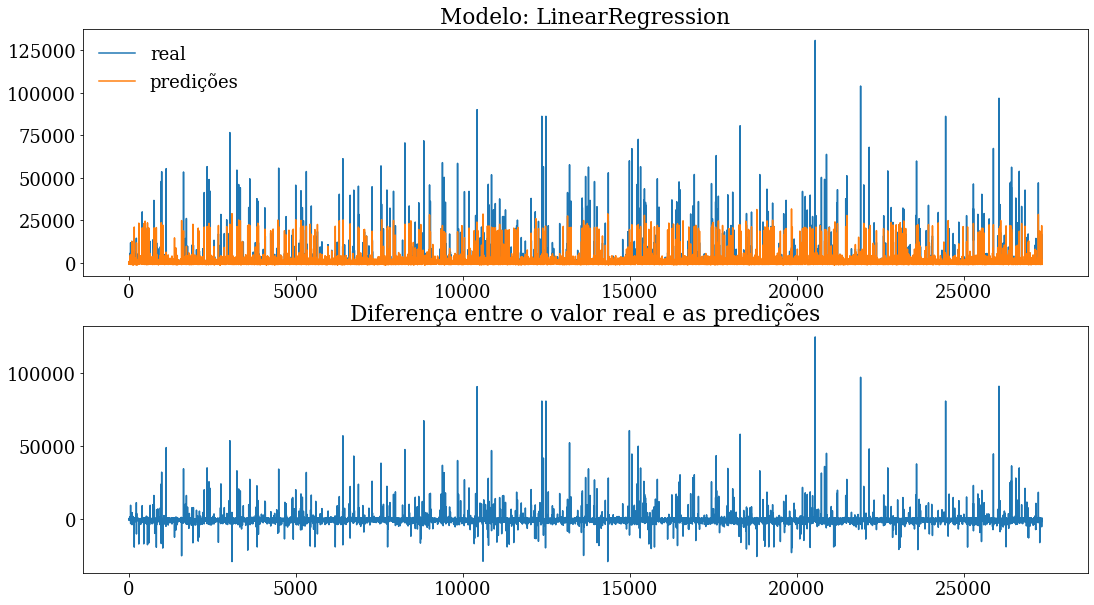

In [42]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

pred_LR_train = model_LR.predict(X_train)
pred_LR_test = model_LR.predict(X_test)

metrics(pred_LR_train, pred_LR_test)

plot(y_train, pred_LR_train, 'LinearRegression')

### Modelo RandomForestRegressor

In [43]:
from sklearn.ensemble import RandomForestRegressor

------------------------------------------------------------
mean_squared_error
Train = 1761.8986009848522 | Test = 2089.0912284431965
------------------------------------------------------------

------------------------------------------------------------
median_absolute_error
Train = 60.18408749695329 | Test = 72.2640874969533
------------------------------------------------------------

------------------------------------------------------------
mean_absolute_percentage_error
Test = 2.2973722565649184 | Train = 2.300141354663869
------------------------------------------------------------


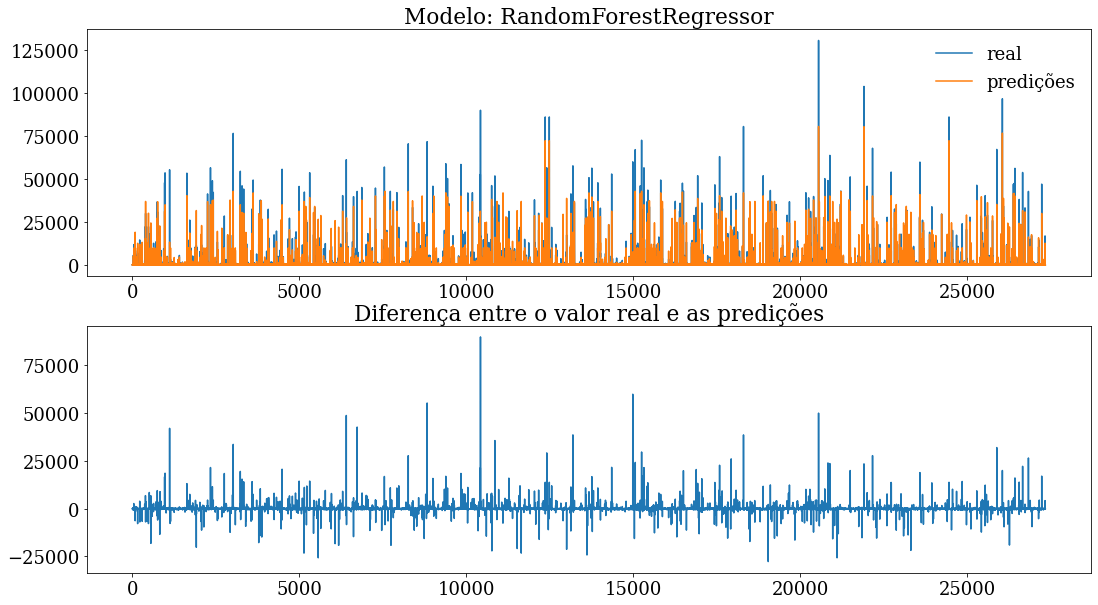

In [44]:
model_RFR = RandomForestRegressor(n_estimators=150, criterion='mse', 
                                   max_depth=4, random_state=42)
model_RFR.fit(X_train, y_train)

pred_RFR_train = model_RFR.predict(X_train)
pred_RFR_test = model_RFR.predict(X_test)

metrics(pred_RFR_train, pred_RFR_test)

plot(y_train, pred_RFR_train, 'RandomForestRegressor')

##### Treinando o modelo RandomForestRegression com o target modificado, ou seja, transformando y em ln(y)

------------------------------------------------------------
mean_squared_error
Train = 0.5119015312697583 | Test = 0.6331961020675777
------------------------------------------------------------

------------------------------------------------------------
median_absolute_error
Train = 0.26132208521896816 | Test = 0.23491884197709112
------------------------------------------------------------

------------------------------------------------------------
mean_absolute_percentage_error
Test = 0.09382994265008338 | Train = 0.08928178859193564
------------------------------------------------------------


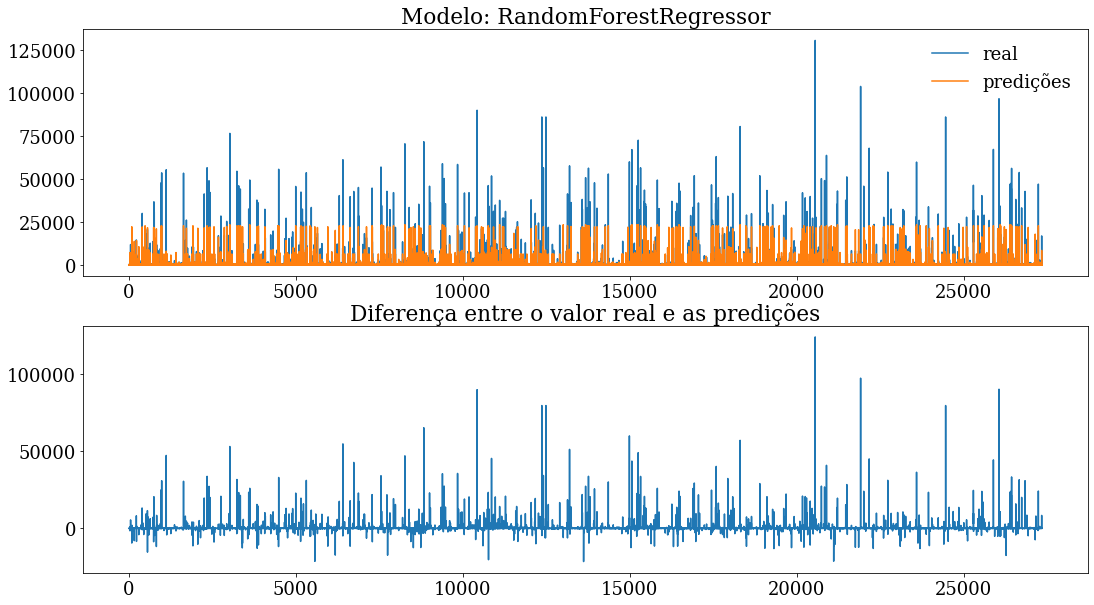

In [45]:
model_RFR_ln = RandomForestRegressor(n_estimators=150, criterion='mse', 
                                   max_depth=4, random_state=42)
model_RFR_ln.fit(X_train, np.log(y_train))

pred_RFR_ln_train = model_RFR_ln.predict(X_train)
pred_RFR_ln_test = model_RFR_ln.predict(X_test)

metrics(pred_RFR_ln_train, pred_RFR_ln_test, np.log(y_train), np.log(y_test))

plot(y_train, np.exp(pred_RFR_ln_train), 'RandomForestRegressor')

Conseguimos reduzir os erros com essa modificação, mas o modelo erra bastante quando o valor real do frete está acima de R$ 2500,00.

### Modelo GradientBoostingRegressor

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

------------------------------------------------------------
mean_squared_error
Train = 866.8395582323021 | Test = 1999.6841731996237
------------------------------------------------------------

------------------------------------------------------------
median_absolute_error
Train = 25.81724632880654 | Test = 47.02170139644511
------------------------------------------------------------

------------------------------------------------------------
mean_absolute_percentage_error
Test = 1.058667691289626 | Train = 0.6056486807034025
------------------------------------------------------------


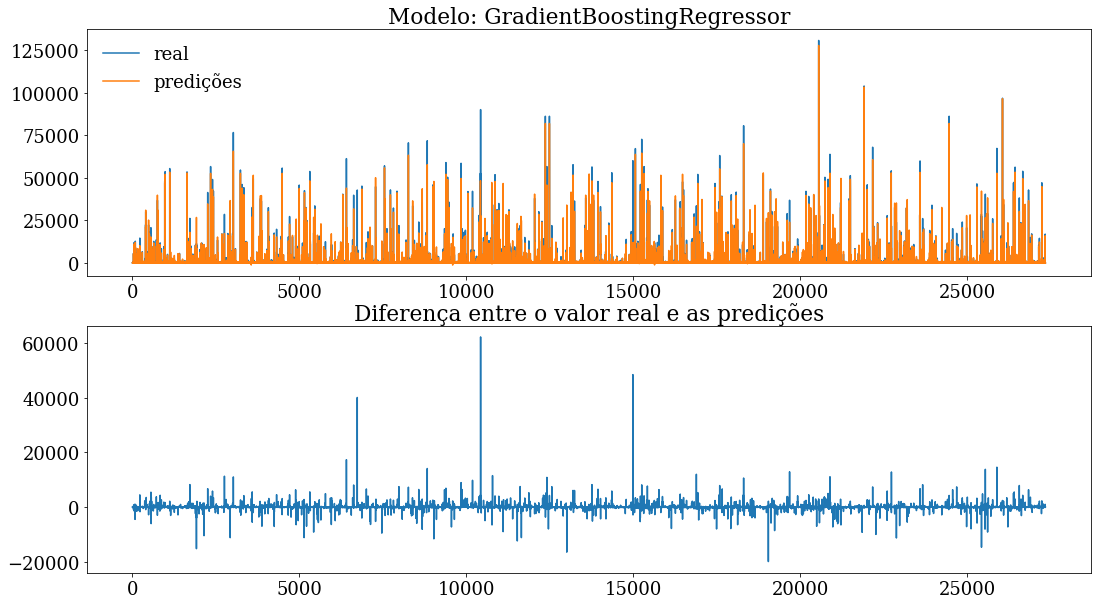

In [47]:
model_GBR = GradientBoostingRegressor(n_estimators=150, max_depth=4, 
                                      random_state=42)
model_GBR.fit(X_train, y_train)

pred_GBR_train = model_GBR.predict(X_train)
pred_GBR_test = model_GBR.predict(X_test)

metrics(pred_GBR_train, pred_GBR_test)

plot(y_train, pred_GBR_train, 'GradientBoostingRegressor')

### Resumo dos erros de cada modelo utilizado

#### Mean Squared Error

- Modelo LinearRegression: 
 - Train = 3058.8275018862537 
 - Test = 4029.0011831166994

- Modelo RandomFoerestRegression
 - Train = 1761.8986009848522 
 - Test = 2089.0912284431965

- Modelo RandomFoerestRegression - com o ln(target)
 - Train = 0.5119015312697583 
 - Test = 0.6331961020675777

- Modelo GradientBoostingRegression
 - Train = 866.8395582323021 
 - Test = 1999.6841731996237

#### Median Absolute Error

- Modelo LinearRegression: 
 - Train = 475.8846077459551 
 - Test = 679.5997814696431

- Modelo RandomFoerestRegression:
 - Train = 60.18408749695329 
 - Test = 72.2640874969533 

- Modelo RandomFoerestRegression - com o ln(target):
 - Train = 0.26132208521896816 
 - Test = 0.23491884197709112

- Modelo GradientBoostingRegression
 - Train = 25.81724632880654 
 - Test = 47.02170139644511

#### Mean Absolute Percentage Error

- Modelo LinearRegression: 
 - Train = 10.584493317101405
 - Test = 11.290700977472765  

- Modelo RandomFoerestRegression:
 - Train = 2.300141354663869
 - Test = 2.2973722565649184 

- Modelo RandomFoerestRegression - com o ln(target):
 - Train = 0.08928178859193564
 - Test = 0.09382994265008338  

- Modelo GradientBoostingRegression
 - Train = 0.6056486807034025
 - Test = 1.058667691289626 

 
 


### Comparação grafica dos modelos nos dados de teste

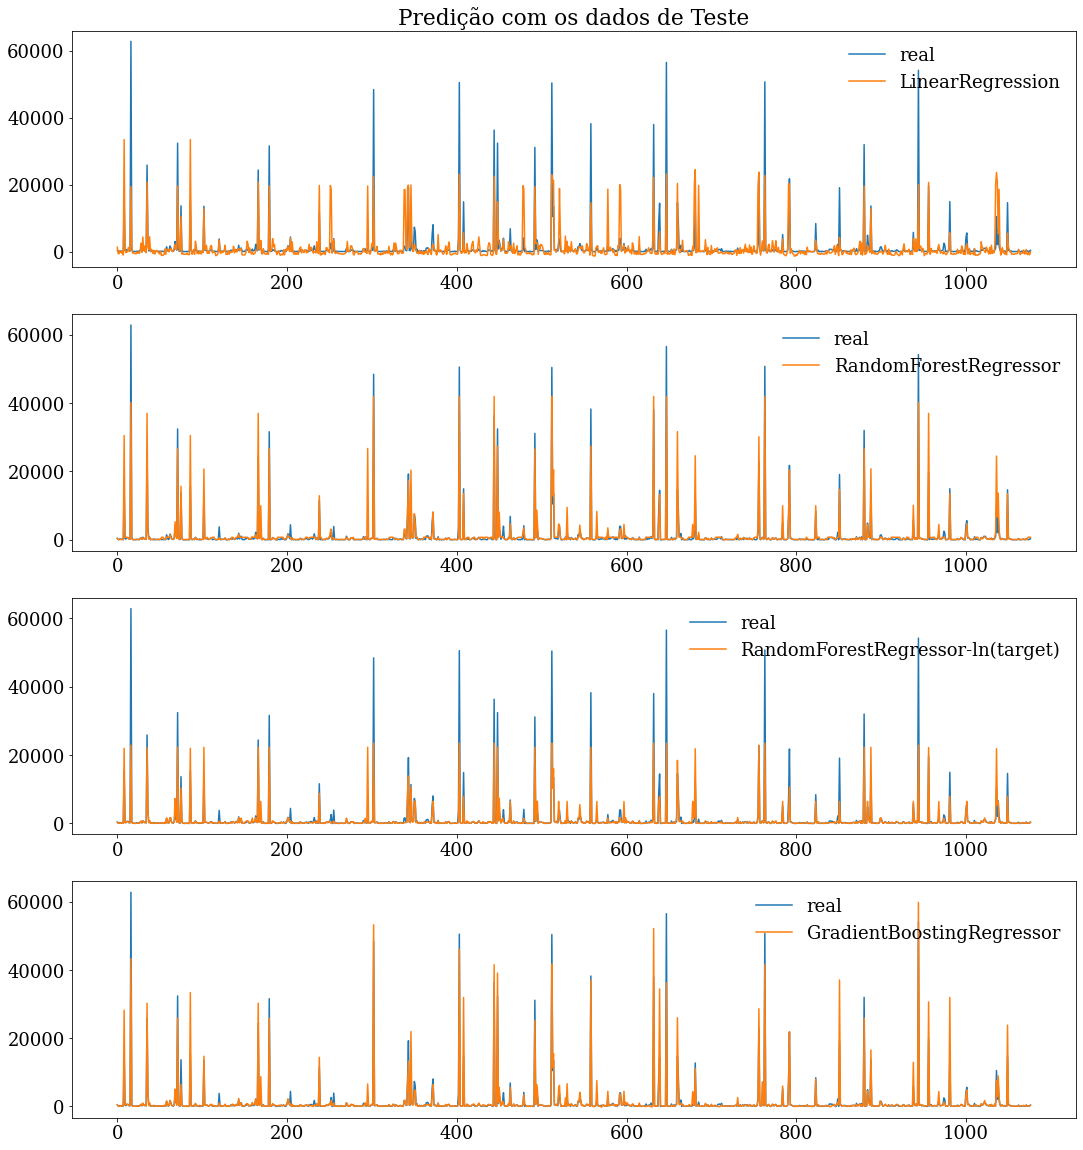

In [87]:
plt.figure(figsize=(18,20))
plt.subplot(4,1,1)
plt.title('Predição com os dados de Teste')
plt.plot(y_test[:], label='real')
plt.plot(pred_LR_test[:], label='LinearRegression')
plt.legend(frameon=False)

plt.subplot(4,1,2)
plt.plot(y_test[:], label='real')
plt.plot(pred_RFR_test, label='RandomForestRegressor')
plt.legend(frameon=False)

plt.subplot(4,1,3)
plt.plot(y_test[:], label='real')
plt.plot(np.exp(pred_RFR_ln_test), label='RandomForestRegressor-ln(target)')
# plt.ylim((0,6100))
plt.legend(frameon=False)

plt.subplot(4,1,4)
plt.plot(y_test[:], label='real')
plt.plot(pred_GBR_test, label='GradientBoostingRegressor')
plt.legend(frameon=False)

plt.savefig('predicao_com_os_dados_de_teste.png',bbox_inches='tight')
plt.show()

Dentro dos modelos analisados, o ``GrandienBoostingRegressor`` apresentou o melhor resultado com relação as 3 metricas utilizadas. Bem como podemos ver visualmente nos gráficos acima que as previsões do modelo ``GrandienBoostingRegressor`` é a que se aproxima melhor do valor real, quando o frete cobrado é maior que R$ 2500,00 reais.


### Ranking de Empresas com o valor do frete "mais em conta"

In [84]:
def previsao(volume, mes, distancia_km, produto_num):
    x = [ [volume, mes, distancia_km, produto_num, empresa_convert_num[e]] 
             for e in empresa_convert_num.keys()]    
    return model_GBR.predict(x)

def apresentacao_resultado(volume, mes, distancia_km, produto_num):
    dados = pd.DataFrame(data={
        'Volume': [volume],
        'Mes': [mes],
        'Distancia_KM':[distancia_km],
        'Produto': [num_convert_produto[produto_num]]
    }).head()

    resultado = pd.DataFrame(data={
        'Empresa': list(empresa_convert_num.keys()),
        'Valor (R$)': np.round(previsao(volume, mes, distancia_km, produto_num), 2)
    }).sort_values(['Valor (R$)'])

    return dados, resultado    

def apresentacao_resultado_grafico(resultado):
    # r_min, *_, r_max = resultado['Valor (R$)'].values
    resultado.head(20).set_index('Empresa').sort_values('Valor (R$)', ascending=False).\
    plot(kind='barh', figsize=(11,7), 
        grid=False, color='darkgreen', 
        legend=False)
    plt.xlabel('Valor (R$)')
    plt.ylabel('')
    # plt.xlim((r_min-100, r_max+100))
    plt.show()    

#### Para o caso

- Volume (m$^3$): 1000;
- Mês: 12;
- Distância (km): 500
- Produto: Madeira serrada (prancha)

In [85]:
dados, resultado = apresentacao_resultado(1000, 12, 500, 5)

print('--'*30)
print(dados)
print('--'*30+'\n')
resultado

------------------------------------------------------------
   Volume  Mes  Distancia_KM                    Produto
0    1000   12           500  Madeira serrada (prancha)
------------------------------------------------------------



,Empresa,Valor (R$)
0,EAA,38214.21
1,OURO VERDE IMP E EXP LTDA,38214.21
2,J. F. VENTURIN - (ME),38214.21
3,JCMN,38214.21
4,LAMINADOS TRIUNFO LTDA,38554.08
5,OUTROS,38554.08
6,OSN,38554.08
7,W. F. DOS SANTOS - (ME),39616.58
8,MADEIREIRA SÃO LUCAS LTDA.,39616.58
9,OURO BRANCO MADEIRAS IMP. E EXP. LTDA.,51183.28


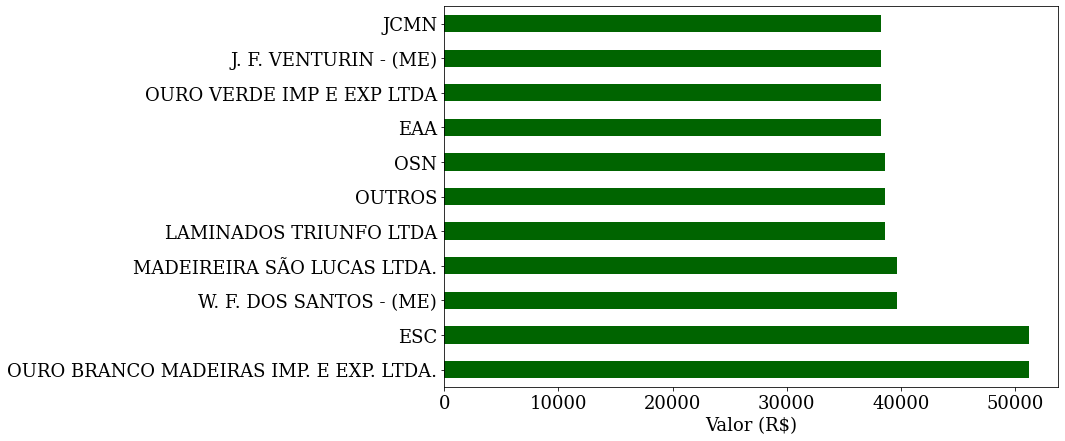

In [86]:
apresentacao_resultado_grafico(resultado)